Find the optimal number of hidden neurons for first hidden layer of the 4-layer network (3 hidden layers, output layer) designed in Question 1 and 2

#### Plot the mean cross-validation accuracies on the final epoch for different combinations of depth and widths using a scatter plot. Limit the search space of the combos to {[64], [128], [256], [64, 64], [128, 128], [256, 256], [64, 128], [128, 64], [128, 256], [64, 256], [256, 128], [256, 64], [64, 64, 64], [128, 128, 128], [256, 256, 256], [64, 128, 256], [64, 256, 256], [128, 64, 64], [128, 128, 64], [256, 128, 64], [256, 256, 128]}. Continue using 5-fold cross validation on training dataset. Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

This might take a while to run, approximately 30 - 60 min, so plan your time carefully.

1.Firstly, we import relevant libraries.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from common_utils import set_seed

# setting seed
set_seed()

2.To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [2]:
# Import the necessary functions from the common_utils.py file
from common_utils import loss_fn, intialise_loaders, EarlyStopper, kfold_preprocess

In [3]:
# Load the dataset
df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

df['label'].value_counts()

# Preprocess the dataset
X_train, y_train, X_test, y_test = kfold_preprocess(df)

3.Perform hyperparameter tuning for the different neurons with 5-fold cross validation.

In [4]:
def train(model, X_train_scaled, y_train2, X_test_scaled, y_test2, batch_size):
    # Define the variables from QA1
    no_epochs = 100  # Define the number of epochs
    learning_rate = 0.001  # Learning rate for the optimizer
    patience = 3  # Patience for the early stopper
    
    # Define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Define the early stopper
    early_stopper = EarlyStopper(patience=patience)
    
    # Define the dataloaders
    train_dataloader, test_dataloader = intialise_loaders(X_train_scaled, y_train2, X_test_scaled, y_test2, batch_size)
    
    # Define the lists to store the accuracy and loss values
    train_accuracies = []
    test_accuracies = []
    train_losses = []
    test_losses = []
    times = []
    
    for epoch in range(no_epochs):
                # Start the timer
                start_time = time.time()
                # Set the model to train mode
                model.train()
                # Loop through the mini-batches and train the model
                for X_batch, y_batch in train_dataloader:
                    optimizer.zero_grad()  # Zero the gradients
                    y_pred = model(X_batch)  # Perform a forward pass of the model
                    loss = loss_fn(y_pred, y_batch)  # Compute the loss value between the predictions and the actual target values
                    loss.backward()  # Backpropagate the gradients
                    optimizer.step()  # Update the model parameters
                
                
                # Define the variables to store the training and test accuracy and loss values
                test_loss, test_accuracy = 0, 0  # Define variables to store the loss and accuracy values for the test dataset
                train_loss, train_accuracy = 0, 0  # Define variables to store the loss and accuracy values for the training dataset
                
                # Define the variables to store the number of mini-batches and the size of the dataset
                test_no_batches = len(test_dataloader)  # Define the number of mini-batches in the test dataset
                test_size = len(test_dataloader.dataset) # Define the size of the dataset
                train_no_batches = len(train_dataloader)  # Define the number of mini-batches in the training dataset
                train_size = len(train_dataloader.dataset)  # Define the size of the dataset
                
                # Set the model to evaluation mode
                model.eval()
                
                # Disable gradient computation using the no_grad context, reducing memory consumption
                with torch.no_grad():
                    # Compute the test accuracy and loss
                    for X_batch, y_batch in test_dataloader:
                        y_pred = model(X_batch)  # Perform a forward pass of the model
                        loss = loss_fn(y_pred, y_batch)  # Compute the loss value between the predictions and the actual target values
                        
                        # Compute the test accuracy and loss for the current batch
                        test_loss += loss.item()  # Add the loss value to the running total
                        test_accuracy += ((y_pred > 0.5) == y_batch).sum().item()  # Compute the number of correctly classified samples and add to the running total
                    
                    # Compute the training accuracy and loss
                    for X_batch, y_batch in train_dataloader:
                        y_pred = model(X_batch)  # Perform a forward pass of the model
                        loss = loss_fn(y_pred, y_batch)  # Compute the loss value between the predictions and the actual target values
                        
                        # Compute the training accuracy and loss for the current batch
                        train_loss += loss.item()  # Add the loss value to the running total
                        train_accuracy += ((y_pred > 0.5) == y_batch).sum().item()  # Compute the number of correctly classified samples and add to the running total
                    
                # Compute the average test and test accuracy and loss values
                test_accuracy /= test_size  # Compute the average test accuracy
                test_loss /= test_no_batches  # Compute the average test loss
                
                # Compute the average training accuracy and loss values
                train_accuracy /= train_size  # Compute the average training accuracy
                train_loss /= train_no_batches  # Compute the average training loss
                    
                # Append the results to the lists
                end_time = time.time()  # Compute the time taken for the epoch
                times.append(end_time - start_time)  # Append the time taken to the list
                test_accuracies.append(test_accuracy)  # Append the test accuracy to the list
                test_losses.append(test_loss)  # Append the test loss to the list
                train_accuracies.append(train_accuracy)  # Append the training accuracy to the list
                train_losses.append(train_loss)  # Append the training loss to the list
                
                if early_stopper.early_stop(test_loss): 
                    print(f"Batch size {batch_size}, Epoch stopped at {epoch + 1} with test loss: {test_loss:.4f} and test accuracy: {test_accuracy:.4f}")
                    break

    return train_accuracies, train_losses, test_accuracies, test_losses, times

In [5]:
# Define the custom class to create the MLP with various number of layers and neurons in the hidden layers
class MLP(nn.Module):
    def __init__(self, no_features, no_hidden, no_labels):
        super().__init__()
        layers = []
        for i in range(len(no_hidden)):
            # Add linear layer from input to hidden layer
            layers.append(nn.Linear(no_features if i == 0 else no_hidden[i-1], no_hidden[i]))
            # Add ReLU activation function
            layers.append(nn.ReLU())
            # Add dropout layer
            layers.append(nn.Dropout(p=0.2))
        # Add output layer
        layers.append(nn.Linear(no_hidden[-1], no_labels))
        layers.append(nn.Sigmoid())  # Sigmoid activation function for binary classification
        
        self.mlp_stack = nn.Sequential(*layers)

    def forward(self, x):
        # Pass the input tensor through the layers
        return self.mlp_stack(x)


In [6]:
def find_optimal_hyperparameter(X_train, y_train, parameters, mode, batch_size):
    # Define the dictionaries to store the mean cross-validation accuracies and the time taken to train the network on the last epoch for the different batch sizes
    cross_validation_accuracies = {}
    cross_validation_times = {}
    cross_validation_losses = {}
    
    # Define the number of folds for the k-fold cross-validation
    no_folds = 5
    
    no_features = X_train.shape[1]  # Number of input features
    
    # Loop through the different network depth-width architectures
    for net_arch in parameters:
        # Define the k-fold cross-validation
        kf = KFold(n_splits=no_folds, shuffle=True, random_state=0)
        
        # Define the list to store the accuracies, losses and times for the different network architectures
        net_arch_accuracies = []
        net_arch_times = []
        net_arch_losses = []
        
        # Print the current architecture being tested
        print(f"Testing {net_arch}")
        
        # Loop through the different folds
        for train_index, val_index in kf.split(X_train):
            # For every batch size, iterate through the different folds that split the dataset into training and validation datasets
            X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]  # Split the training and validation datasets with the features
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]  # Split the training and validation datasets with the labels
            
            # Scale the input features for the subset of the training set (training + validation from k-fold cross-validation)
            # This won't affect the test set and the whole training set as it is scaled separately (X_train_scaled and X_test_scaled are scaled later independently from the k-fold cross-validation)
            scaler = preprocessing.StandardScaler()
            X_train_fold = scaler.fit_transform(X_train_fold)
            X_val_fold = scaler.transform(X_val_fold)
            
            # Define the model
            model = MLP(no_features, net_arch, 1)
            
            # Train the model
            train_accuracies, train_losses, test_accuracies, test_losses, times = train(model, X_train_fold, y_train_fold, X_val_fold, y_val_fold, batch_size)
            
            # Store the accuracies, losses and times (for the last epoch) for the current fold into the network architecture lists
            net_arch_accuracies.append(test_accuracies[-1])
            net_arch_times.append(times[-1])
            net_arch_losses.append(test_losses[-1])
            
        # Store the mean cross-validation accuracy and time taken to train the network on the last epoch
        cross_validation_accuracies[str(net_arch)] = np.mean(net_arch_accuracies)
        cross_validation_times[str(net_arch)] = np.mean(net_arch_times)
        cross_validation_losses[str(net_arch)] = np.mean(net_arch_losses)

    return cross_validation_accuracies, cross_validation_times, cross_validation_losses

optimal_bs = 128 # The optimal batch size found in QA2
# List of the combinations of neurons to be tested
num_neurons = [[64], [128], [256], [64, 64], [128, 128], [256, 256], [64, 128], [128, 64], [128, 256], [64, 256], [256, 128], [256, 64], [64, 64, 64], [128, 128, 128], [256, 256, 256], [64, 128, 256], [64, 256, 256], [128, 64, 64], [128, 128, 64], [256, 128, 64], [256, 256, 128]]
cross_validation_accuracies, cross_validation_times, cross_validation_losses = find_optimal_hyperparameter(X_train.to_numpy(), y_train, num_neurons, 'num_neurons', optimal_bs)

Testing [64]
Batch size 128, Epoch stopped at 32 with test loss: 0.5869 and test accuracy: 0.6899
Batch size 128, Epoch stopped at 18 with test loss: 0.6348 and test accuracy: 0.6379
Batch size 128, Epoch stopped at 16 with test loss: 0.6219 and test accuracy: 0.6593
Batch size 128, Epoch stopped at 9 with test loss: 0.6551 and test accuracy: 0.6173
Batch size 128, Epoch stopped at 16 with test loss: 0.6383 and test accuracy: 0.6272
Testing [128]
Batch size 128, Epoch stopped at 21 with test loss: 0.6006 and test accuracy: 0.6904
Batch size 128, Epoch stopped at 27 with test loss: 0.5836 and test accuracy: 0.6821
Batch size 128, Epoch stopped at 28 with test loss: 0.5813 and test accuracy: 0.7013
Batch size 128, Epoch stopped at 18 with test loss: 0.6165 and test accuracy: 0.6604
Batch size 128, Epoch stopped at 29 with test loss: 0.5918 and test accuracy: 0.6963
Testing [256]
Batch size 128, Epoch stopped at 20 with test loss: 0.5831 and test accuracy: 0.7076
Batch size 128, Epoch sto

4.Plot the mean cross-validation accuracies on the final epoch for different combinations of depth and widths using a scatter plot. Limit the search space of the combos to {[64], [128], [256], [64, 64], [128, 128], [256, 256], [64, 128], [128, 64], [128, 256], [64, 256], [256, 128], [256, 64], [64, 64, 64], [128, 128, 128], [256, 256, 256], [64, 128, 256], [64, 256, 256], [128, 64, 64], [128, 128, 64], [256, 128, 64], [256, 256, 128]}.

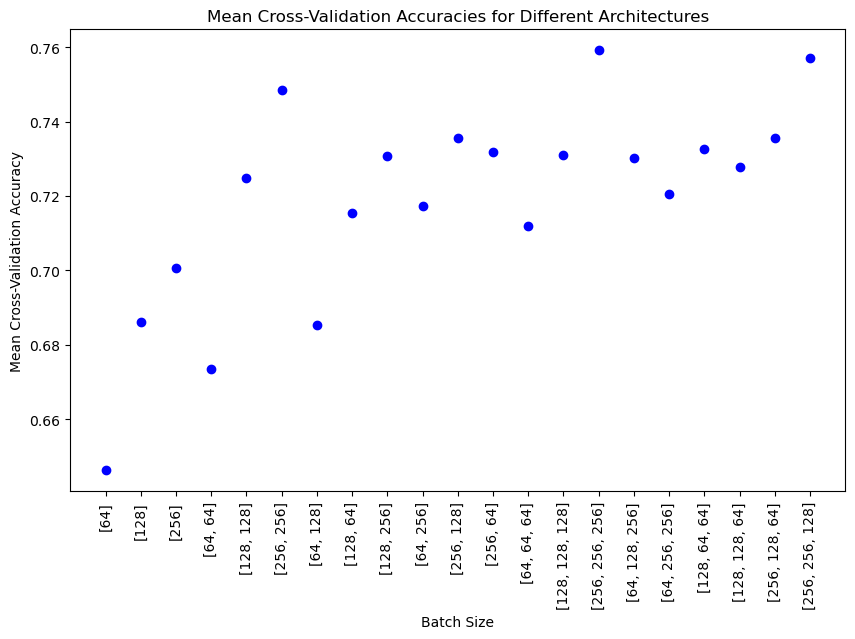

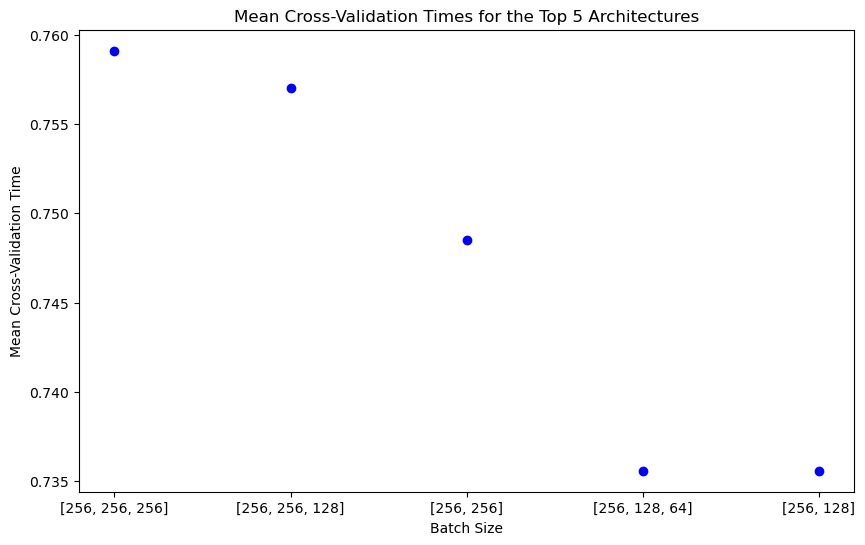

In [7]:
# Plot the mean cross-validation accuracies on the final epoch for different combinations of depth and widths using a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(cross_validation_accuracies.keys(), cross_validation_accuracies.values(), color='blue')
plt.title('Mean Cross-Validation Accuracies for Different Architectures')
plt.xlabel('Batch Size')
plt.xticks(rotation=90)
plt.ylabel('Mean Cross-Validation Accuracy')
plt.show()

#Plot the mean cross-validation accuracies on the final epoch for the top 5 combinations of depth and widths using a scatter plot
top_5_combos = dict(sorted(cross_validation_accuracies.items(), key=lambda item: item[1], reverse=True)[:5])
plt.figure(figsize=(10, 6))
plt.scatter(top_5_combos.keys(), top_5_combos.values(), color='blue')
plt.title('Mean Cross-Validation Times for the Top 5 Architectures')
plt.xlabel('Batch Size')
plt.ylabel('Mean Cross-Validation Time')
plt.show()

5.Select the optimal combination for the depth and width. State the rationale for your selection.

In [8]:
optimal_combination = [256, 256, 256]
reason = """
As we are asked to select the optimal combination for the depth and width of the neural network based on the mean cross-validation accuracies for the final epoch, the optimal combination is [256, 256, 256]. This is because it has the highest mean cross-validation accuracy of around 76%. This means that the model with this combination of depth and width has the highest accuracy in predicting the target variable.
"""

print(f'The optimal combination of depth and width is {optimal_combination}')
print(f'Reason: {reason}')

The optimal combination of depth and width is [256, 256, 256]
Reason: 
As we are asked to select the optimal combination for the depth and width of the neural network based on the mean cross-validation accuracies for the final epoch, the optimal combination is [256, 256, 256]. This is because it has the highest mean cross-validation accuracy of around 76%. This means that the model with this combination of depth and width has the highest accuracy in predicting the target variable.


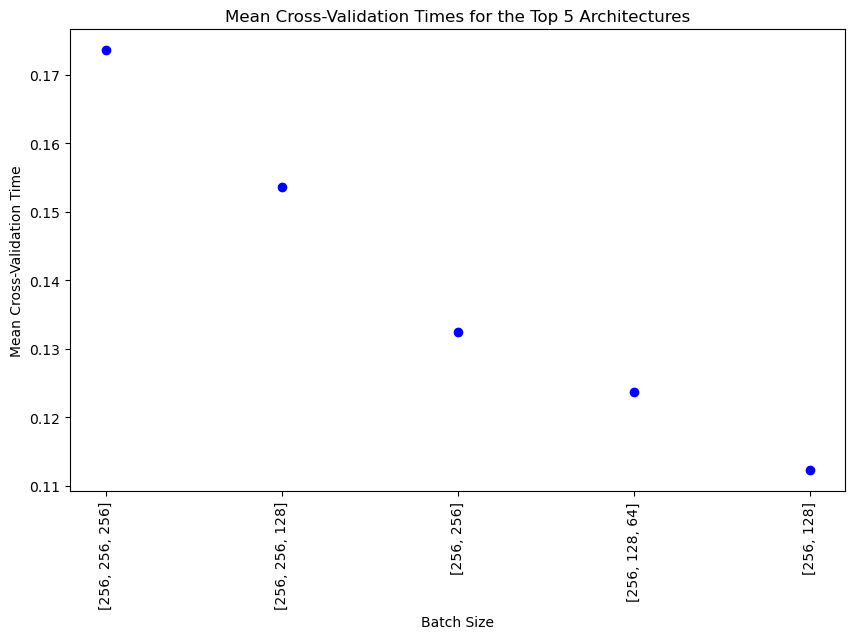

In [9]:
# Get the times for the top 5 combinations which we selected previously
top_5_combos_times = {key: cross_validation_times[key] for key in top_5_combos.keys()}

# Plot the mean cross-validation times for the top 5 combinations with the highest accuracy of depth and widths using a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(top_5_combos_times.keys(), top_5_combos_times.values(), color='blue')
plt.title('Mean Cross-Validation Times for the Top 5 Architectures')
plt.xlabel('Batch Size')
plt.xticks(rotation=90)
plt.ylabel('Mean Cross-Validation Time')
plt.show()

In [10]:
# More efficient combination of depth and width
efficient_combination = [256, 256]
reason = """
However, if we consider the time taken to train the network on the last epoch, the combination [256, 256] has much lower time taken to train the network on the last epoch with less than 1% difference in the accuracy. We consider [256, 256] because is the close to the optimal combination of [256, 256, 256] and needs less time for the final epoch. This means that the model with this combination of depth and width has high accuracy in predicting the target variable and is more efficient in terms of time taken to train the network on the last epoch.
"""

print(f'The efficient combination of depth and width is {efficient_combination}')
print(f'Reason: {reason}')

The efficient combination of depth and width is [256, 256]
Reason: 
However, if we consider the time taken to train the network on the last epoch, the combination [256, 256] has much lower time taken to train the network on the last epoch with less than 1% difference in the accuracy. We consider [256, 256] because is the close to the optimal combination of [256, 256, 256] and needs less time for the final epoch. This means that the model with this combination of depth and width has high accuracy in predicting the target variable and is more efficient in terms of time taken to train the network on the last epoch.


6.Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.


In [11]:
print(f"The optimal combination of depth and width is {optimal_combination}")
print(f"The optimal batch size is {optimal_bs}")

# Define the number of features
no_features = X_train.shape[1]
print(no_features)

# Define the model with the optimal combination of depth and width
model = MLP(no_features, optimal_combination, 1)

# Scale the input features for the whole training set (training + validation from k-fold cross-validation) and the test set
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model
train_accuracies, train_losses, test_accuracies, test_losses, times = train(model, X_train_scaled, y_train, X_test_scaled, y_test, optimal_bs)

The optimal combination of depth and width is [256, 256, 256]
The optimal batch size is 128
77
Batch size 128, Epoch stopped at 18 with test loss: 0.5260 and test accuracy: 0.7629


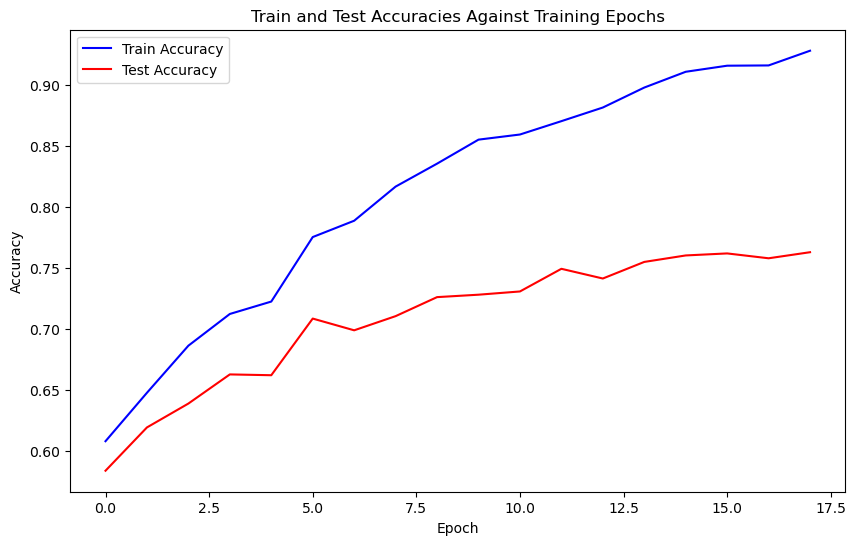

In [12]:
# Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.plot(test_accuracies, label='Test Accuracy', color='red')
plt.title('Train and Test Accuracies Against Training Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

7.As you've astutely observed, we're facing a significant challenge in enumerating all possible combinations of widths and depths and searching over them. Given the circumstances, could you explore and implement a more efficient method for searching through these combinations that could significantly reduce the computational time but achieve similar search results?

Referring to this article: https://www.yourdatateacher.com/2021/05/19/hyperparameter-tuning-grid-search-and-random-search/
We can use Random Search to search through the combinations of widths and depths. Random Search is a hyperparameter tuning method that can be used to search through a wide range of hyperparameters. It is more efficient than Grid Search as it does not require the exhaustive search of all possible combinations of hyperparameters. Instead, it randomly selects a combination of hyperparameters to evaluate. This can significantly reduce the computational time but achieve similar search results.

In [13]:
# Define the list to hold a random sample of the full num_neurons list, with 30% of the combinations
random_combinations = random.sample(num_neurons, int(0.3 * len(num_neurons)))
print(f"New Random Sample of the network combinations: {random_combinations})")

# Perform the random search
random_cross_validation_accuracies, random_cross_validation_times, random_cross_validation_losses = find_optimal_hyperparameter(X_train.to_numpy(), y_train, random_combinations, 'num_neurons', optimal_bs)

New Random Sample of the network combinations: [[64, 64, 64], [128, 128, 128], [128], [128, 256], [64, 256, 256], [64, 128, 256]])
Testing [64, 64, 64]
Batch size 128, Epoch stopped at 34 with test loss: 0.5485 and test accuracy: 0.7308
Batch size 128, Epoch stopped at 19 with test loss: 0.5913 and test accuracy: 0.6871
Batch size 128, Epoch stopped at 28 with test loss: 0.5523 and test accuracy: 0.7212
Batch size 128, Epoch stopped at 28 with test loss: 0.5630 and test accuracy: 0.7190
Batch size 128, Epoch stopped at 19 with test loss: 0.6051 and test accuracy: 0.6748
Testing [128, 128, 128]
Batch size 128, Epoch stopped at 21 with test loss: 0.5326 and test accuracy: 0.7374
Batch size 128, Epoch stopped at 30 with test loss: 0.5461 and test accuracy: 0.7407
Batch size 128, Epoch stopped at 20 with test loss: 0.5501 and test accuracy: 0.7345
Batch size 128, Epoch stopped at 32 with test loss: 0.5056 and test accuracy: 0.7594
Batch size 128, Epoch stopped at 22 with test loss: 0.5670 

Now let's plot the mean cross-validation accuracies on the final epoch for different combinations of depth and widths using a scatter plot.

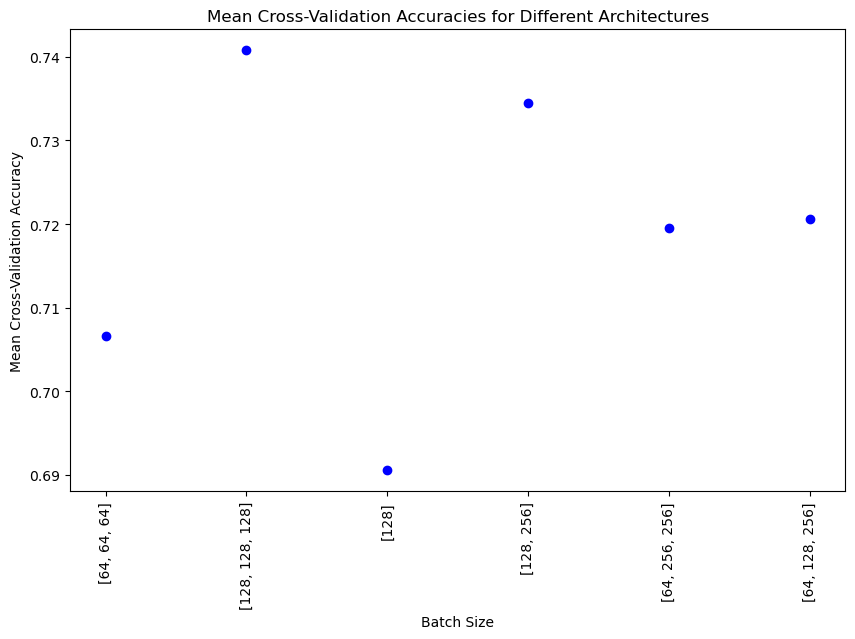

In [14]:
# Plot the mean cross-validation accuracies on the final epoch for different combinations of depth and widths using a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(random_cross_validation_accuracies.keys(), random_cross_validation_accuracies.values(), color='blue')
plt.title('Mean Cross-Validation Accuracies for Different Architectures')
plt.xlabel('Batch Size')
plt.xticks(rotation=90)
plt.ylabel('Mean Cross-Validation Accuracy')
plt.show()

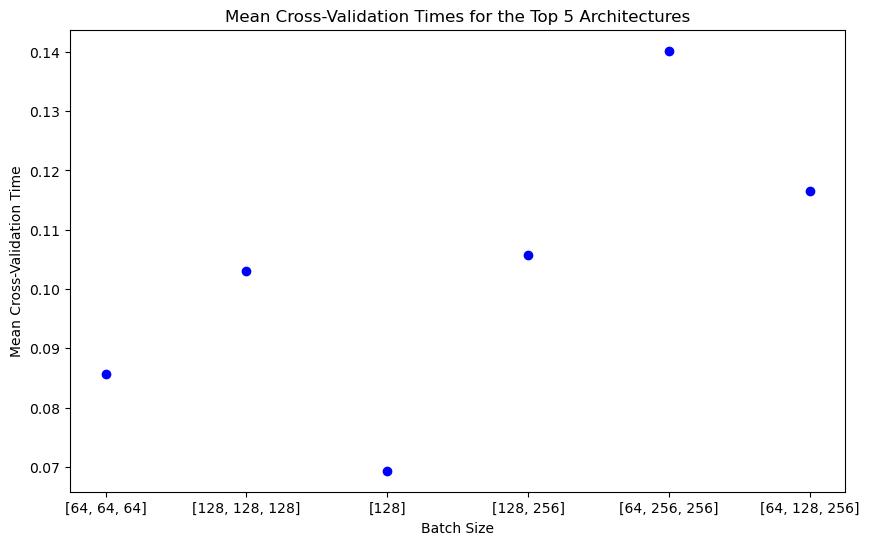

In [15]:
# Plot the mean cross-validation times for combinations
plt.figure(figsize=(10, 6))
plt.scatter(random_cross_validation_times.keys(), random_cross_validation_times.values(), color='blue')
plt.title('Mean Cross-Validation Times for the Top 5 Architectures')
plt.xlabel('Batch Size')
plt.ylabel('Mean Cross-Validation Time')
plt.show()

In [16]:
# Define the best random combination
best_random_combination = [128, 128, 128]

# Define the model with the best random combination
model = MLP(no_features, best_random_combination, 1)

# Train a model with the best random combination
random_train_accuracies, random_train_losses, random_test_accuracies, random_test_losses, random_times = train(model, X_train_scaled, y_train, X_test_scaled, y_test, optimal_bs)

Batch size 128, Epoch stopped at 18 with test loss: 0.5354 and test accuracy: 0.7386


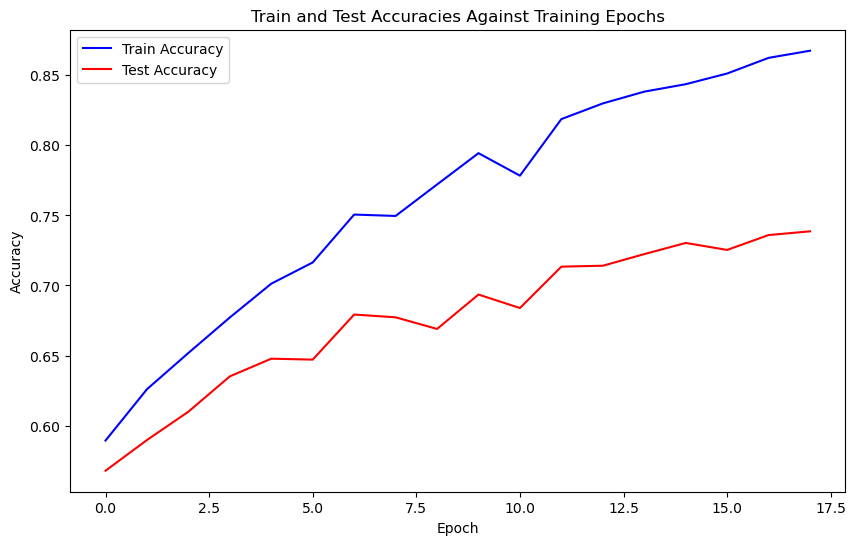

In [17]:
# Plot the train and test accuracies against training epochs with the best random number of neurons using a line plot
plt.figure(figsize=(10, 6))
plt.plot(random_train_accuracies, label='Train Accuracy', color='blue')
plt.plot(random_test_accuracies, label='Test Accuracy', color='red')
plt.title('Train and Test Accuracies Against Training Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [18]:
comment = """
As we can see from the graph, the best random combination of depth and width is [128, 128, 128]. This combination has a high accuracy in predicting the target variable and is more efficient in terms of time taken to train the network on the last epoch. Compared to the optimal combination of depth and width, [256, 256, 256], the best random combination has a similar accuracy and even takes less time to train the network on the last epoch. This means that the model with this combination of depth and width has high accuracy in predicting the target variable and is more efficient in terms of time taken to train the network on the last epoch.
Thus, we can consider the Random Search approach successful.
"""
print(f"The best random combination of depth and width is {best_random_combination}")
print(f"Comment: {comment}")

The best random combination of depth and width is [128, 128, 128]
Comment: 
As we can see from the graph, the best random combination of depth and width is [128, 128, 128]. This combination has a high accuracy in predicting the target variable and is more efficient in terms of time taken to train the network on the last epoch. Compared to the optimal combination of depth and width, [256, 256, 256], the best random combination has a similar accuracy and even takes less time to train the network on the last epoch. This means that the model with this combination of depth and width has high accuracy in predicting the target variable and is more efficient in terms of time taken to train the network on the last epoch.
Thus, we can consider the Random Search approach successful.
